In [ ]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Start with a fresh ResNet-18
model = models.resnet18()

# 2. Setup the "Head" to match your V6 (6 classes)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 6) 

# 3. Load the weights into that 6-class structure
# We use weights_only=True to follow the new safety recommendation
state_dict = torch.load('witcher_multiclass_v6.pth', map_location=device, weights_only=True)
model.load_state_dict(state_dict)

# 4. Now perform the "Surgery" to upgrade to 9 classes
model.fc = nn.Linear(num_ftrs, 9)

# 5. Move to GPU
model = model.to(device)

print("Success! Model weights loaded and upgraded to 9 classes.")

In [ ]:
import os
import splitfolders

# Update this to your actual desktop path
base_path = r'./GameFace-AI'

input_folder = os.path.join(base_path, "dataset")
output_folder = os.path.join(base_path, "split_data")

# Check if input folder exists
if os.path.exists(input_folder):
    print(f"Found input folder at: {input_folder}")
    # Let's also see what classes we have
    classes = [d for d in os.listdir(input_folder) if os.path.isdir(os.path.join(input_folder, d))]
    print(f"Classes found: {classes}")
    
    # Show image counts per class
    for cls in classes:
        count = len(os.listdir(os.path.join(input_folder, cls)))
        print(f"  {cls}: {count} images")
else:
    print("Error: Could not find the input folder!")

In [ ]:
# Split with 80/20 ratio
# seed=42 ensures reproducibility
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8, .2))

print("--- Split Complete ---")
print(f"Check: {output_folder} should now contain 'train' and 'val' folders.")

# Let's verify the split worked correctly
print("\n--- Verifying Split ---")
for split in ['train', 'val']:
    split_path = os.path.join(output_folder, split)
    if os.path.exists(split_path):
        print(f"\n{split.upper()} set:")
        classes = [d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))]
        for cls in classes:
            count = len(os.listdir(os.path.join(split_path, cls)))
            print(f"  {cls}: {count} images")

In [ ]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.08, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomPerspective(distortion_scale=0.4, p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Point to the split folders
data_dir = os.path.join(base_path, "split_data")

# Load datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}

# Create dataloaders (batch_size=16 like the binary model)
dataloaders = {x: DataLoader(image_datasets[x], batch_size=16, shuffle=True)
               for x in ['train', 'val']}

# Store class names and dataset sizes
class_names = image_datasets['train'].classes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

print(f"Classes found: {class_names}")
print(f"Training images: {dataset_sizes['train']}")
print(f"Validation images: {dataset_sizes['val']}")

In [ ]:
# Freeze all parameters
for param in model.parameters():
    param.requires_grad = False

# Unfreeze ONLY the new 9-class head
for param in model.fc.parameters():
    param.requires_grad = True

# Standard Learning Rate for the head
optimizer_phase1 = optim.Adam(model.fc.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [ ]:
best_val_acc = 0.0
epochs_no_improve = 0

print(f"Starting training on {device}...")

for epoch in range(5):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloaders["train"]:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer_phase1.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_phase1.step()
        running_loss += loss.item() * inputs.size(0)

    # --- Validation Phase ---
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in dataloaders["val"]:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(dataloaders["train"].dataset)
    epoch_acc = 100. * val_correct / val_total
    
    print(f"Epoch {epoch+1}/{5} - Loss: {epoch_loss:.4f} | Val Acc: {epoch_acc:.2f}%")

    # --- Checkpoint & Early Stopping Logic ---
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print("Model saved!")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= 3:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

print(f"Training finished. Best Accuracy: {best_val_acc:.2f}%")

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, dataloader, class_names):
    """
    Evaluate model and return predictions and true labels
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_preds, all_labels

# Run evaluation on validation set
print("Evaluating on validation set...")
val_preds, val_labels = evaluate_model(model, dataloaders['val'], class_names)

# Calculate overall accuracy
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(val_labels, val_preds)
print(f"\nOverall Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")

In [ ]:
# 1. CONFUSION MATRIX
print("\n" + "="*60)
print("CONFUSION MATRIX")
print("="*60)

cm = confusion_matrix(val_labels, val_preds)

# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Character Classifier', fontsize=14, pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# 2. PER-CLASS ACCURACY
print("\n" + "="*60)
print("PER-CLASS ACCURACY")
print("="*60)

for i, class_name in enumerate(class_names):
    class_correct = cm[i, i]
    class_total = cm[i, :].sum()
    class_acc = class_correct / class_total if class_total > 0 else 0
    print(f"{class_name:12s}: {class_correct:2d}/{class_total:2d} = {class_acc:.2%}")

# 3. DETAILED CLASSIFICATION REPORT
print("\n" + "="*60)
print("CLASSIFICATION REPORT (Precision, Recall, F1)")
print("="*60)
print(classification_report(val_labels, val_preds, target_names=class_names, digits=4))

In [ ]:
# 1. Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

# 2. Setup the Differential Learning Rate Optimizer
optimizer = optim.Adam([
    {'params': model.conv1.parameters(), 'lr': 1e-6}, 
    {'params': model.layer1.parameters(), 'lr': 1e-6},
    {'params': model.layer2.parameters(), 'lr': 1e-5},
    {'params': model.layer3.parameters(), 'lr': 1e-5},
    {'params': model.layer4.parameters(), 'lr': 1e-4}, 
    {'params': model.fc.parameters(),     'lr': 1e-4}  
], lr=1e-4)

best_val_acc = 0.0
epochs_no_improve = 0
total_epochs = 40

print(f"Starting Phase 2 (Fine-Tuning) on {device}...")

for epoch in range(total_epochs):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloaders["train"]:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad() # Changed from optimizer_phase1
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()      #  Changed from optimizer_phase1
        
        running_loss += loss.item() * inputs.size(0)

    # --- Validation Phase ---
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in dataloaders["val"]:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(dataloaders["train"].dataset)
    epoch_acc = 100. * val_correct / val_total
    
    # Updated print for clarity
    print(f"Epoch {epoch+1}/{total_epochs} - Loss: {epoch_loss:.4f} | Val Acc: {epoch_acc:.2f}%")

    # --- Checkpoint & Early Stopping ---
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'witcher_sekiro_v8.pth') 
        print(f"New Best Accuracy! Model saved.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= 5:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

print(f"Training finished. Best Accuracy: {best_val_acc:.2f}%")

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, dataloader, class_names):
    """
    Evaluate model and return predictions and true labels
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_preds, all_labels

# Run evaluation on validation set
print("Evaluating on validation set...")
val_preds, val_labels = evaluate_model(model, dataloaders['val'], class_names)

# Calculate overall accuracy
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(val_labels, val_preds)
print(f"\nOverall Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")

In [ ]:
# 1. CONFUSION MATRIX
print("\n" + "="*60)
print("CONFUSION MATRIX")
print("="*60)

cm = confusion_matrix(val_labels, val_preds)

# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Character Classifier', fontsize=14, pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# 2. PER-CLASS ACCURACY
print("\n" + "="*60)
print("PER-CLASS ACCURACY")
print("="*60)

for i, class_name in enumerate(class_names):
    class_correct = cm[i, i]
    class_total = cm[i, :].sum()
    class_acc = class_correct / class_total if class_total > 0 else 0
    print(f"{class_name:12s}: {class_correct:2d}/{class_total:2d} = {class_acc:.2%}")

# 3. DETAILED CLASSIFICATION REPORT
print("\n" + "="*60)
print("CLASSIFICATION REPORT (Precision, Recall, F1)")
print("="*60)
print(classification_report(val_labels, val_preds, target_names=class_names, digits=4))

In [ ]:
# Create a dictionary to store everything needed for deployment
checkpoint = {
    'model_state_dict': model.state_dict(),
    'class_names': class_names,
    'model_architecture': 'resnet18',
    'input_size': 224
}

# Save the comprehensive file
torch.save(checkpoint, 'gameface_classifier_final.pth')
print("Production model exported with class metadata!")

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import cv2
import os
from ultralytics import YOLO

# 1. SETUP & CONFIGURATION
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CONFIDENCE_THRESHOLD = 0.85  # Only auto-label if ResNet is >85% sure
VIDEO_PATH = 'Sekiro - _For the Sake of Ashina_ _ Ultimate Genichiro _ No HUD Boss Fight.mp4'  # Path to your video file
OUTPUT_DIR = 'auto_labeled_data'
CLASS_NAMES = ['ciri', 'genichiro', 'geralt', 'isshin', 'other', 'sekiro', 'triss', 'vesemir', 'yennefer']

# 2. LOAD THE BRAIN
def load_classifier(path):
    model = models.resnet18()
    model.fc = nn.Linear(model.fc.in_features, len(CLASS_NAMES))
    model.load_state_dict(torch.load(path, map_location=device))
    model = model.to(device)
    model.eval()
    return model

classifier = load_classifier('witcher_sekiro_v8.pth')

# 3. LOAD THE SCOUT (YOLOv8)
# This model is pre-trained to find 'person' (Class 0)
detector = YOLO('yolov8n.pt') 

# 4. PREPROCESSING TRANSFORM
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create folders
for name in CLASS_NAMES + ['uncertain']:
    os.makedirs(os.path.join(OUTPUT_DIR, name), exist_ok=True)

# 5. PROCESSING LOOP
cap = cv2.VideoCapture(VIDEO_PATH)
frame_count = 0

print("Starting Auto-Labeling...")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret: break
    
    # Process every 5th frame to avoid near-identical images
    if frame_count % 5 == 0:
        # Detect humans using YOLO
        results = detector(frame, classes=[0], verbose=False) # class 0 is 'person'
        
        for r in results:
            for box in r.boxes:
                # Extract coordinates
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                
                # Crop and Convert to PIL
                crop = frame[max(0, y1):y2, max(0, x1):x2]
                if crop.size == 0: continue
                
                img_pil = Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
                img_t = transform(img_pil).unsqueeze(0).to(device)
                
                # Classify with ResNet
                with torch.no_grad():
                    outputs = classifier(img_t)
                    probs = torch.nn.functional.softmax(outputs, dim=1)
                    conf, pred = torch.max(probs, 1)
                    
                    label = CLASS_NAMES[pred.item()]
                    score = conf.item()
                
                # Save into folders
                save_name = f"frame_{frame_count}_box_{pred.item()}.jpg"
                if score >= CONFIDENCE_THRESHOLD:
                    save_path = os.path.join(OUTPUT_DIR, label, save_name)
                else:
                    save_path = os.path.join(OUTPUT_DIR, 'uncertain', save_name)
                
                cv2.imwrite(save_path, crop)
                
    frame_count += 1
    if frame_count % 100 == 0:
        print(f"Processed {frame_count} frames...")

cap.release()
print(f"Done! Check the '{OUTPUT_DIR}' folder.")

In [ ]:
import json

# class_names was defined as image_datasets['train'].classes in your notebook
class_mapping = {i: name for i, name in enumerate(class_names)}

with open('class_mapping.json', 'w') as f:
    json.dump(class_mapping, f)

print("Class mapping saved to class_mapping.json")
# Example output based on your notebook: {0: 'ciri', 1: 'genichiro', 2: 'geralt', ...}

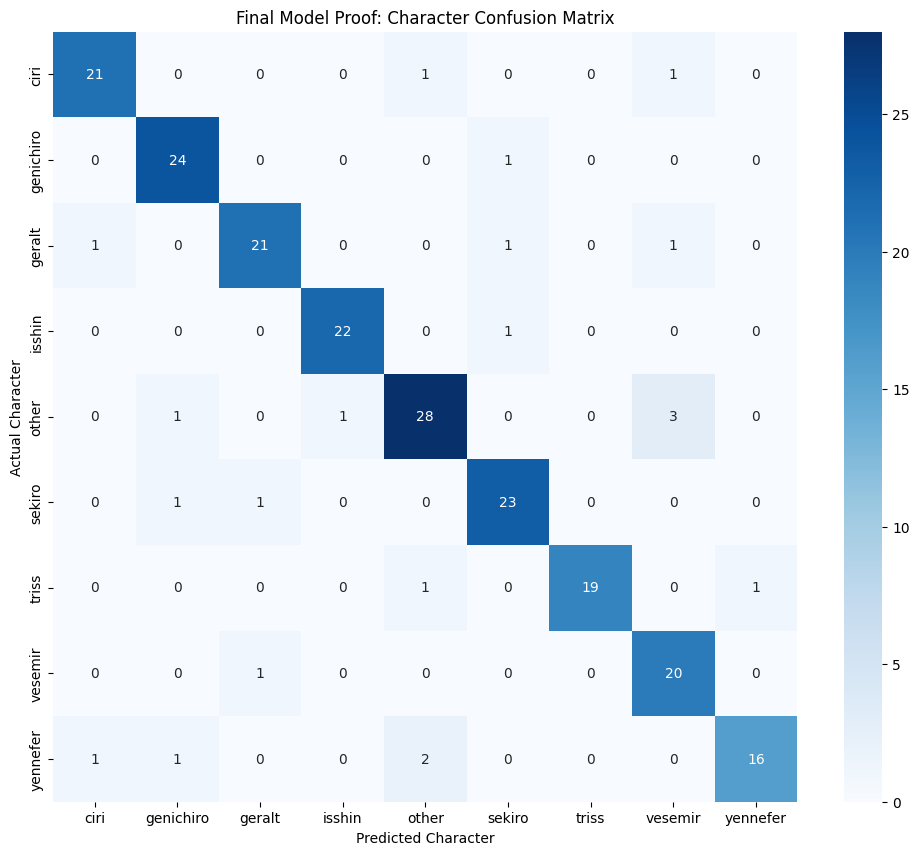


Final Performance Summary:
              precision    recall  f1-score   support

        ciri       0.91      0.91      0.91        23
   genichiro       0.89      0.96      0.92        25
      geralt       0.91      0.88      0.89        24
      isshin       0.96      0.96      0.96        23
       other       0.88      0.85      0.86        33
      sekiro       0.88      0.92      0.90        25
       triss       1.00      0.90      0.95        21
     vesemir       0.80      0.95      0.87        21
    yennefer       0.94      0.80      0.86        20

    accuracy                           0.90       215
   macro avg       0.91      0.90      0.90       215
weighted avg       0.91      0.90      0.90       215



In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Since you don't have a history dict, we will use the val_preds 
# and val_labels from your existing evaluation cell
def show_final_proof(y_true, y_pred, class_names):
    # 1. Confusion Matrix Heatmap
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Final Model Proof: Character Confusion Matrix')
    plt.ylabel('Actual Character')
    plt.xlabel('Predicted Character')
    plt.show()

    # 2. Text Summary
    print("\nFinal Performance Summary:")
    print(classification_report(y_true, y_pred, target_names=class_names))

# Run this using the variables already in your notebook
show_final_proof(val_labels, val_preds, class_names)